In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

<Figure size 800x600 with 0 Axes>

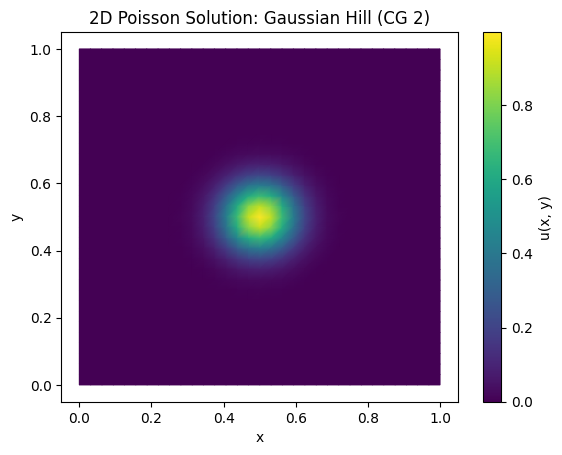

Mesh resolution: Δx = 0.0625
L2 error: 0.00030039516852498017


<Figure size 800x600 with 0 Axes>

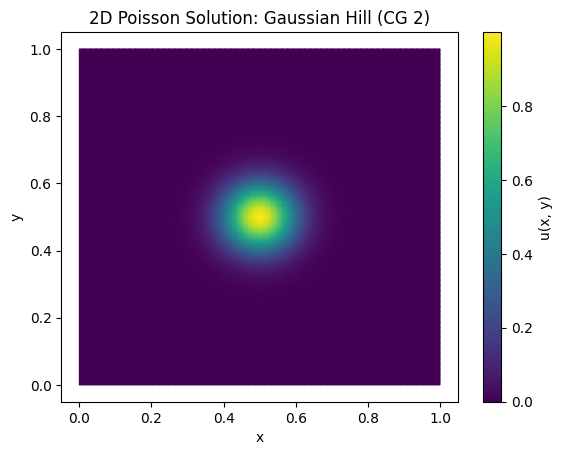

Mesh resolution: Δx = 0.03125
L2 error: 2.1183802287497694e-05


<Figure size 800x600 with 0 Axes>

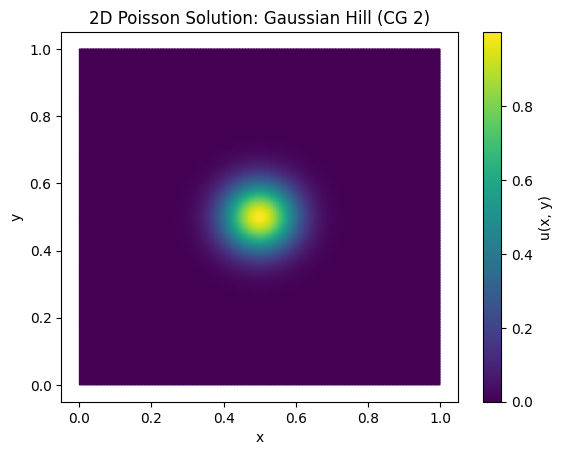

Mesh resolution: Δx = 0.015625
L2 error: 1.37388799812676e-06


<Figure size 800x600 with 0 Axes>

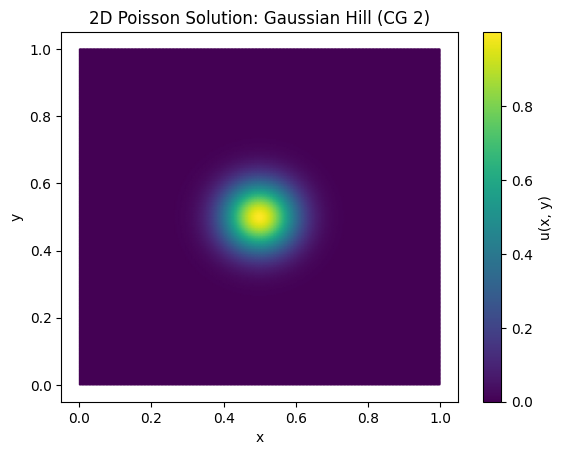

Mesh resolution: Δx = 0.0078125
L2 error: 8.716915465279913e-08


<Figure size 800x600 with 0 Axes>

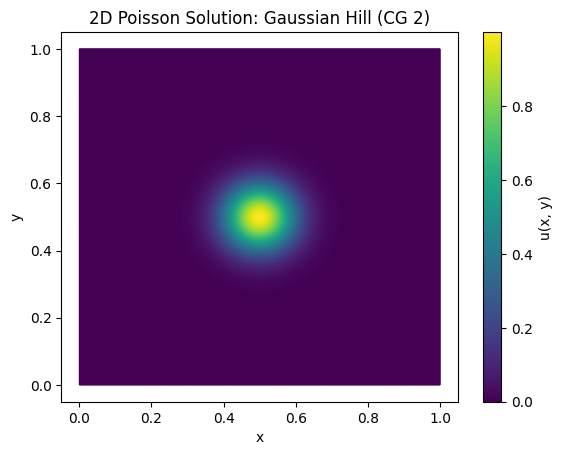

Mesh resolution: Δx = 0.00390625
L2 error: 6.4117577796236955e-09


In [2]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

def get_difference2(u_sol, grid, order, CG="CG1"):
    # u_sol is already the function, no need to index it like a dict
    mesh = u_sol.function_space().mesh()
    x, y = SpatialCoordinate(mesh)
    V = u_sol.function_space()

    u_exact = Function(V, name="u_exact")
    center_dist = (x - 0.5)**2 + (y - 0.5)**2
    u_exact_expr = exp(-100 * center_dist)
    u_exact.interpolate(u_exact_expr)

    diff1 = Function(V, name="error")
    # Use u_sol directly here
    diff1.interpolate(abs(u_sol - u_exact))

    outfile = VTKFile(f"outputdiff_{grid}_{order}.pvd")
    outfile.write(u_sol, u_exact, diff1)




def solve_poisson(n_res,degree=1,save_data=False):
    mesh = UnitSquareMesh(n_res, n_res, quadrilateral=True)
    V = FunctionSpace(mesh, 'CG', degree)

    x, y = SpatialCoordinate(mesh)

    # --- Step 6: Define new exact solution and source f ---
    # Using a Gaussian Hill: u = exp(-100 * ((x-0.5)**2 + (y-0.5)**2))
    # This creates a "tiny curved area" in the center of the domain.
    center_dist = (x - 0.5)**2 + (y - 0.5)**2
    u_exact_expr = exp(-100 * center_dist)

    # f = -div(grad(u)). For this Gaussian, f is derived via calculus:
    f_expr = 400 * (1 - 100 * center_dist) * exp(-100 * center_dist)

    f = Function(V).interpolate(f_expr)
    u_sol = Function(V, name="Solution")
    v = TestFunction(V)
    u_trial = TrialFunction(V)

    # --- Variational Form ---
    a = inner(grad(u_trial), grad(v)) * dx
    L = f * v * dx

    # --- Boundary Conditions ---
    # Setting Dirichlet on all boundaries (1, 2, 3, 4) based on exact solution
    bc = DirichletBC(V, u_exact_expr, "on_boundary")

    # Solve
    solve(a == L, u_sol, bcs=bc,
          solver_parameters={'ksp_type': 'cg', 'pc_type': 'ilu'})

    # --- Error Analysis ---
    u_exact_fn = Function(V).interpolate(u_exact_expr)
    l2_error = errornorm(u_exact_fn, u_sol, 'L2')

    if save_data:
      outfile = VTKFile(f'Q6output_{n_res}_{degree}.pvd')
      outfile.write(u_sol)

    return n_res, l2_error, u_sol


nres=[16,32,64,128,256]

errors=[]

for i in nres:
    res, l2_error,u_sol = solve_poisson(i,degree=2,save_data=True)
    plt.figure(figsize=(8, 6))
    contours = tripcolor(u_sol)
    plt.colorbar(contours, label='u(x, y)')
    plt.title("2D Poisson Solution: Gaussian Hill (CG 2)")
    plt.xlabel("x")
    plt.ylabel("y")
    if i==128:
      plt.savefig("newanalytical.png",format="png",bbox_inches="tight",dpi=1000)
    plt.show()
    get_difference2(u_sol,i,2)
    print(f'Mesh resolution: Δx = {1/res}')
    print(f'L2 error: {l2_error}')
    errors.append(l2_error)



Observed convergence rate (slope): -3.90


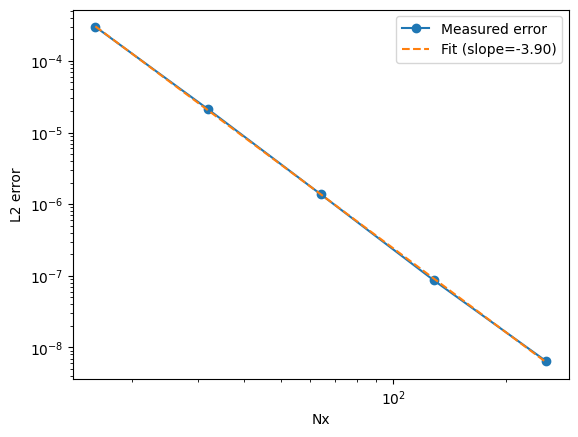

In [ ]:

# log–log data
logN = np.log(nres)
logE = np.log(errors)

# linear fit in log–log space
slope, intercept = np.polyfit(logN, logE, 1)

print(f"Observed convergence rate (slope): {slope:.2f}")

# fitted line
fit_errors = np.exp(intercept) * nres**slope

# plot
plt.figure()
plt.loglog(nres, errors, "o-", label="Measured error")
plt.loglog(nres, fit_errors, "--", label=f"Fit (slope={slope:.2f})")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Nx')
plt.ylabel('L2 error')
plt.legend()
plt.savefig("Analyticalresidual.png",format="png",bbox_inches="tight",dpi=1000)
plt.show()